# Variational Autoencoder for Audio
In this notebook, I will attempt to implement a VAE for generating similar sounds as those in a Spoken Digit audio Database. 

In [1]:
%matplotlib inline
import IPython.display

import gzip
import cPickle as pickle
import pandas as pd
import random
import seaborn
import librosa

from librosa.display import waveplot, specshow
seaborn.set(style='ticks')

In [2]:
dbfile ='../SpokenDigitDB.pkl.gz'
with gzip.open(dbfile, 'rb') as ifile:
    df = pickle.load(ifile)
    print('File loaded as '+ dbfile)    

File loaded as ../SpokenDigitDB.pkl.gz


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509 entries, 0 to 4508
Data columns (total 7 columns):
Class        4509 non-null category
Magnitude    4509 non-null object
PShift       4509 non-null int64
Phase        4509 non-null object
SIndex       4509 non-null int64
TStretch     4509 non-null float64
Wave         4509 non-null object
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 215.9+ KB


Maximum length is: 138 


(array([  60.,   63.,  123.,  138.,  123.,  180.,  177.,  180.,  186.,
         135.,  276.,  171.,  255.,  216.,  195.,  174.,  174.,  132.,
         111.,  156.,  225.,  126.,  162.,   90.,   90.,   54.,   27.,
          72.,   42.,   33.,   75.,   57.,   39.,   42.,   15.,   33.,
          15.,   12.,    9.,    6.,    6.,    3.,    3.,   12.,    3.,
           3.,    9.,    3.,    9.,    9.]),
 array([  33. ,   35.1,   37.2,   39.3,   41.4,   43.5,   45.6,   47.7,
          49.8,   51.9,   54. ,   56.1,   58.2,   60.3,   62.4,   64.5,
          66.6,   68.7,   70.8,   72.9,   75. ,   77.1,   79.2,   81.3,
          83.4,   85.5,   87.6,   89.7,   91.8,   93.9,   96. ,   98.1,
         100.2,  102.3,  104.4,  106.5,  108.6,  110.7,  112.8,  114.9,
         117. ,  119.1,  121.2,  123.3,  125.4,  127.5,  129.6,  131.7,
         133.8,  135.9,  138. ]),
 <a list of 50 Patch objects>)

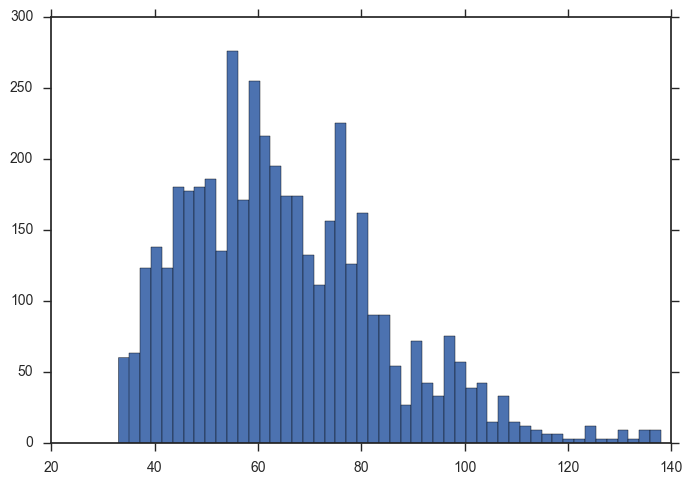

In [4]:
mag = df.Magnitude
mgs = [np.shape(x)[1] for x in mag]
maxlen = np.max(mgs)
print('Maximum length is: {} '.format(maxlen))
plt.hist(mgs,50)

In [5]:
# Padding & Truncating
maxlen = 84
pad    = lambda a, n: a[:,0: n] if a.shape[1] > n else np.hstack((a, np.zeros([a.shape[0],n - a.shape[1]])))

df.Magnitude = df.Magnitude.apply(pad,args=(maxlen,))  # MaxLen Truncation Voodoo :D
df.Phase     = df.Phase.apply(pad,args=(maxlen,))

print(np.unique([np.shape(x)[1] for x in df.Magnitude]))
print(np.unique([np.shape(x)[1] for x in df.Phase]))

[84]
[84]


## Plot Samples from Database

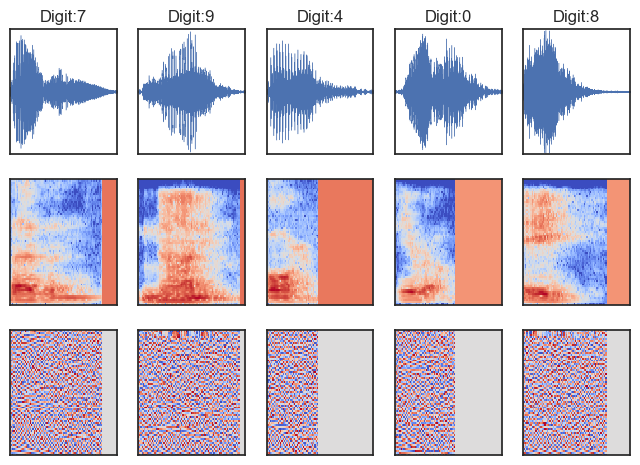

In [6]:
seaborn.set(style='white')

# Plot K Random Examples
k  = 5
sr = 8000

sidx = random.sample(range(len(df)),k)
sidx = np.append(sidx,[sidx,sidx])    

for i,j in enumerate(sidx):
    if i<k:
        subplot(3,k,i+1)
        waveplot(df.Wave[j],sr=sr)
        title('Digit:{1}'.format(j,df.Class[j]))
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().get_xaxis().set_visible(False)

    elif (i>=k and i<2*k):
        subplot(3,k,i+1)
        specshow(df.Magnitude[j],sr=sr)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        
    else:
        subplot(3,k,i+1)
        specshow(df.Phase[j],sr=sr)
        gca().set_xticklabels([])
        gca().set_yticklabels([])        

In [7]:
# np.max(df.Magnitude[j])
# np.max(df.Phase[j])

In [8]:
# Play back an example!
j = sidx[1]
IPython.display.Audio(data=df.Wave[j], rate=sr)

## VAE for Audio

In [9]:
# Imports
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

from keras import metrics
# from keras.datasets import mnist
from scipy.stats import norm

Using TensorFlow backend.


In [10]:
chns, rows, cols = 1, 64, 84
filters = 12

batch_size = 10
latent_dim = 10
middle_dim = 256

epochs = 50
epsilon_std = 1.0
img_size = (rows,cols,chns)

In [11]:
# mag_in = Input(shape=(rows,cols),name='magnitude')
# phi_in = Input(shape=(rows,cols),name='phase')

# # Mag & Phi Encoder
# mconv1 = Conv2D(filters,(3,5),padding='same',activation='relu')(mag_in)
# mconv1 = MaxPooling2D((2,2))(mconv1)
# mconv2 = Conv2D(12,(3,3),padding='same',activation='relu')(mconv1)
# mconv2 = MaxPooling2D((2,3))(mconv2)
# mconv  = Flatten()(mconv2)

# pconv1 = Conv2D(filters,(3,5),padding='same',activation='relu')(phi_in)
# pconv1 = MaxPooling2D((2,2))(pconv1)
# pconv2 = Conv2D(filters,(3,3),padding='same',activation='relu')(pconv1)
# pconv2 = MaxPooling2D((2,3))(pconv2)
# pconv  = Flatten()(pconv2)

# # Intermediate Shared Layer - Encoder
# shared_layer = Dense(middle_dim, activation='relu')
# encoded_m = shared_layer(mconv)
# encoded_p = shared_layer(pconv)
# encoded   = K.concatenate([encoded_m, encoded_p], axis=-1)

# # Latent Distribution
# z_mean = Dense(latent_dim)(encoded)
# z_lvar = Dense(latent_dim)(encoded)

In [12]:
# x = Input(input_shape=(batch_size,)+img_size)
x = Input(shape=img_size)

# Encoder
conv1 = Conv2D(filters,(3,5),padding='same',activation='relu',strides=(1,1))(x)
conv2 = Conv2D(filters,(3,3),padding='same',activation='relu',strides=(2,3))(conv1)
conv3 = Conv2D(filters,(2,2),padding='same',activation='relu',strides=(2,2))(conv2)
conv  = Flatten()(conv3)
encoded = Dense(middle_dim,activation='relu')(conv)

# Latent Distribution
z_mean = Dense(latent_dim)(encoded)
z_lvar = Dense(latent_dim)(encoded)

In [14]:
# Gaussian Sampler
def sampling(args):
    z_mean, z_lvar = args
    bsize = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(bsize, latent_dim),
                              mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_lvar / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_lvar])

In [15]:
# Intermediate Shared Layer - Decoder
decode_h = Dense(middle_dim, activation='relu')(z)

upsample = Dense(filters*16*14, activation='relu')(decode_h)
ureshape = Reshape((16,14,filters))(upsample)

trconv1  = Conv2DTranspose(filters,2,padding='same',
                          activation='relu',strides=2)(ureshape)
trconv2  = Conv2DTranspose(filters,3,padding='same',
                          activation='relu',strides=(2,3))(trconv1)
trconv3  = Conv2DTranspose(filters,(3,5),padding='same',
                          activation='relu',strides=1)(trconv2)

decoded  = Conv2D(chns,2,padding='same',activation='sigmoid')(trconv3)

In [16]:
# def vae_loss(x, decoded):
#     x = K.flatten(x)
#     decoded = K.flatten(decoded)
#     gen_loss = rows * cols * metrics.binary_crossentropy(x, decoded)
#     kl_loss = - 0.5 * K.mean(1 + z_lvar - K.square(z_mean) - K.exp(z_lvar), axis=-1)
#     return K.mean(gen_loss + kl_loss)

In [17]:
# Custom loss layer
class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(VAELossLayer, self).__init__(**kwargs)

    def vae_loss(self, x, decoded):
        x = K.flatten(x)
        decoded = K.flatten(decoded)
        gen_loss = rows * cols * metrics.binary_crossentropy(x, decoded)
        kl_loss = - 0.5 * K.mean(1 + z_lvar - K.square(z_mean) - K.exp(z_lvar), axis=-1)
        return K.mean(gen_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        decoded = inputs[1]
        loss = self.vae_loss(x, decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

y = VAELossLayer()([x,decoded])
vae = Model(x,y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 84, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 84, 12)    192         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 28, 12)    1308        conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 16, 14, 12)    588         conv2d_2[0][0]                   
___________________________________________________________________________________________

/Users/d30676n/anaconda/envs/deeplearn/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: Output "vae_loss_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "vae_loss_layer_1" during training.


In [ ]:
# # Model
# vae = Model(x,decoded)
# vae.compile(optimizer='rmsprop', loss=vae_loss)
# vae.summary()

In [18]:
# Get Training Data
x_data = df.Magnitude.values
x_data = np.dstack(x_data)
x_data = x_data.transpose(2,0,1)
x_data = x_data[...,None]         # add singleton class
# x_data = x_data[:4500]

In [19]:
vae.fit(x_data,
        shuffle=True,
        epochs=epochs,
        batch_size=50,
        callbacks=[TensorBoard(log_dir='/tmp/vautoeconder')])

Epoch 1/50
4509/4509 [==============================] - 29s - loss: 2973160928.4057    
Epoch 2/50
4509/4509 [==============================] - 32s - loss: -2073873.1121    
Epoch 3/50
4509/4509 [==============================] - 30s - loss: -2076190.3963    
Epoch 4/50
4509/4509 [==============================] - 32s - loss: -2079488.6688    
Epoch 5/50
4509/4509 [==============================] - 33s - loss: -2080497.1407    
Epoch 6/50
4509/4509 [==============================] - 34s - loss: -2086657.1446    
Epoch 7/50
4509/4509 [==============================] - 32s - loss: -2087552.3345    
Epoch 8/50
4509/4509 [==============================] - 32s - loss: -2088758.5411    
Epoch 9/50
4509/4509 [==============================] - 34s - loss: -2088467.8643    
Epoch 10/50
4509/4509 [==============================] - 31s - loss: -2089977.4798    
Epoch 11/50
4509/4509 [==============================] - 31s - loss: 10062992.5606    
Epoch 12/50
4509/4509 [===========================

KeyboardInterrupt: 